## 4. Logistische Regression

Eine alternative, besser an das Klassifikationsszenario angepasste Kostenfunktion statt des MSE ist die Kostenfunktion für die logistische Regression:

$$
C = −y * log(a^L) − (1 − y) * log(1 − a^L)
$$

Damit Sie diese in Ihrem Beispiel anwenden können, müssen Sie die Ableitung $∇_{a^L} C$ berechnen und die Funktion `cost_derivative()` entsprechend abändern. Da die logistische Regression davon ausgeht, dass der Output des Netzes eine Wahrscheinlichkeit zwischen 0 und 1 ist, können wir hierfür nicht den $tanh()$ als Aktivierungsfunktion verwenden. 

Machen Sie daher Ihre Änderungen aus Aufgabe 3 rückgängig, so dass Sie wieder eine sigmoide Aktivierungsfunktion haben. In der Funktion `evaluate()` sollte natürlich statt des MSE die Kostenfunktion der logistischen Regression ausgegeben werden, um zu überprüfen, ob
tatsächlich ein Gradientenabstieg stattfindet. Weiterhin ist es nützlich, sowohl auf $C$ wie auf $∇_{a^L} C$ die Funktion `np.nan_to_num()` anzuwenden, da hier zuweilen numerische Probleme auftreten können. Auch die Lernrate muss angepasst werden: $η = 1.0$ funktioniert hier deutlich besser.

### Netzwerkparameter und Initialisierung

Das Netzwerk wird nun wieder mit den alten Netzwerkparametern aus Aufgabe 2 initialisiert jedoch mit angepasster Lernrate::

In [277]:
# Netzwerkparameter laut Aufgabenbeschreibung
mbs = 10                    # Größe des Mini-Batches
eta = 1.0                   # Lernrate eta
epochs = 150                # Anzahl der Epochen
no_hidden = 2               # Anzahl der Neuronen pro versteckter Schicht

# Anzahl der Neuronen pro Schicht (2 Eingabe, 2 versteckte Schichten mit 2 Neuronen, 1 Ausgabe)
layers = [2, no_hidden, no_hidden, 1]

num_layers = len(layers)    # Anzahl der Schichten im Netzwerk
num_layers

4

In [278]:
import numpy as np
biases = [np.random.randn(y, 1) for y in layers[1:]]                        # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(layers[:-1], layers[1:])]  # Gewichte

### Datensätze generieren

In [279]:
import numpy as np

from auxiliary import get_labels, build_design_matrix

# Erstellen der Datenpunkte im vorgegebenen Bereich für Training und Test
X_train = np.random.uniform(-6, 6, (200, 2))
X_test = np.random.uniform(-6, 6, (200, 2))

# Generieren der Labels für Trainings- und Testdaten
y_train = get_labels(X_train)
y_test = get_labels(X_test)

# Erstellen der initialen Gewichtungsvektoren
w_x = np.array([1, 0])
w_y = np.array([0, 1])

xv = np.linspace(-6, 6, 100)
yv = np.linspace(-6, 6, 100)

X, Y = np.meshgrid(xv, yv)

design = np.c_[X.ravel(), Y.ravel()]

design_X_train  = build_design_matrix(X_train, w_x, w_y)
design_X_test   = build_design_matrix(X_test, w_x, w_y)

### Angepasste Hilfsfunktionen

Wie beschrieben müssen die Änderungen aus [Aufgabe 2](exercise_1_2.ipynb) rückgängig gemacht werden so das wieder die sigmoide Aktivierungsfunktion verwendet wird.

In [280]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    """Now it is the sigmoid function again :)"""
    return 1.0/(1.0+np.exp(-z))
    
# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

Zusätzlich soll in dieser Aufgabe die Kostenfunktion für die logistische Regression verwendet werden:

$$
C = −y * log(a^L) − (1 − y) * log(1 − a^L)
$$

Hierzu muss die Ableitung $∇_{a^L} C$ berechnet und die Funktion `cost_derivative()` entsprechend abgeändert werden.

Die Ableitung der logistischen Kostenfunktion nach den Ausgaben lautet:

$$
\frac{\partial C}{\partial a^L} =-\frac{y}{a^L} + \frac{1-y}{1-a}
$$

dies lässt sich noch weiter umformen zu:

$$
\frac{\partial C}{\partial a^L} = \frac{a^L - y}{a^L (1 - a^L)}
$$

Die Funktion `cost` & `cost_derivative()` kann somit wie folgt implementiert werden:

In [281]:
def cost(output_activations, y):
    """Return the cross-entropy cost."""
    # Cost function for logistic regression with C = −y * log(a^L) − (1 − y) * log(1 − a^L)
    return np.nan_to_num(-y * np.log(output_activations) - (1 - y) * np.log(1 - output_activations))

In [282]:
def cost_derivative(output_activations, y):
    # Numerische Stabilität: vermeide Division durch 0 mit np.nan_to_num
    return np.nan_to_num((output_activations - y) / (output_activations * (1.0 - output_activations)))

### Feedforward

In [283]:
def feedforward(a):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

### Evaluate

In [284]:
def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    
    correct = 0     # Anzahl korrekt klassifizierter Testbeispiele
    loss    = []    # Liste zur Speicherung der Verluste (Erweiterung laut Aufgabenbeschreibung)
    
    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        # 
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()

        # Korrektes Label erhalten
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)
        
        # Die Vorhersage ist 1, wenn die Ausgabe >= 0.5 ist, sonst 0
        cpred = 1 if ypred >= 0.5 else 0

        c = y
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        if c == cpred:
            correct += 1

        # Loss berechnen und speichern
        loss.append(cost(ypred, y)) # Costfunction logistic regression
        
    return correct, np.mean(loss)

### Backpropagation-Algorithmus

In [285]:
def backprop(x, y):
    """Return a tuple ``(\nabla_b, nabla_w)`` representing the
    gradient for the cost function C_x.  ``nabla_b`` and
    ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""
    
    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Vorwärtslauf
    activation = x # Initialisierung a^1 = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    
    # Rückwärtslauf
    delta = cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # Fehler am Output
    nabla_b[-1] = delta # Update Schwellwert in der Ausgangsschicht
    nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Update Gewichte in der Ausgangsschicht
    for l in range(2, num_layers): # Backpropagation
        z = zs[-l] # gewichteter Input
        sp = sigmoid_prime(z) # Ableitung der Aktivierungsfunktion
        delta = np.dot(weights[-l+1].transpose(), delta) * sp # Fehler in Schicht l
        nabla_b[-l] = delta # Update Schwellwert 
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Update Gewichte

    return (nabla_b, nabla_w)

### Minibatches

In [286]:
def update_mini_batch(xmb, ymb, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    global weights
    global biases

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Gehe durch alle Beispielpaare im Minibatch
    for i in range(xmb.shape[0]):
        x = np.reshape(xmb[i,:],(xmb.shape[1],1)).copy()
        if len(ymb.shape) == 2:
            y = np.reshape(ymb[i,:],(ymb.shape[1],1)).copy()
        else:
            y = ymb[i].copy()
        
        # Berechne Updates für alle Schichten über Backprop
        delta_nabla_b, delta_nabla_w = backprop(x, y)
        
        # Addiere einzelne Updates auf
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    # Berechne neue Gewichte
    weights = [w-(eta/xmb.shape[0])*nw
                    for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/xmb.shape[0])*nb
                   for b, nb in zip(biases, nabla_b)]
    
    return (weights, biases)

### Stochastischer Gradientenabstieg (SGD)

In [287]:
def SGD(x0, y0, epochs, mini_batch_size, eta, x2, y2):

    n_test = x2.shape[0] # Anzahl Testdaten
    n = x0.shape[0]      # Anzahl Trainingsdaten
    
    precision_curve = []  # Liste zur Speicherung der Präzisionswerte (Erweiterung laut Aufgabenbeschreibung)
    mse_curve = []        # Liste zur Speicherung der MSE-Werte (Erweiterung laut Aufgabenbeschreibung)

    # gehe durch alle Epochen
    acc_val = np.zeros(epochs)
    print("| Epochs | Precision | Loss   |")
    for j in range(epochs):
        
        # Bringe die Trainingsdaten in eine zufällige Reihenfolge für jede Epoche
        p = np.random.permutation(n) # Zufällige Permutation aller Indizes von 0 .. n-1
        x0 = x0[p,:]
        y0 = y0[p]
        
        # Zerlege den permutierten Datensatz in Minibatches 
        for k in range(0, n, mini_batch_size):
            xmb = x0[k:k+mini_batch_size,:]
            if len(y0.shape) == 2:
                ymb = y0[k:k+mini_batch_size,:]
            else:
                ymb = y0[k:k+mini_batch_size]
            update_mini_batch(xmb, ymb, eta)
        
        # Gib Performance aus
        acc_val[j], loss = evaluate(x2, y2)

        precision_curve.append(acc_val[j] / n_test)  # Präzisionswert speichern
        mse_curve.append(loss)              # MSE-Wert speichern

        if j % 10 == 0 or j == epochs - 1:
            print("|  {:>5} |   {:>6.4f}  | {:>6.4f} |".format(j+1, precision_curve[-1], mse_curve[-1]))
    
    return acc_val, precision_curve, mse_curve

### Training des Netzwerk

In [288]:
acc_val, precision, loss = SGD(design_X_train, y_train, epochs, mbs, eta, X_test, y_test)

| Epochs | Precision | Loss   |
|      1 |   0.4550  | 0.6957 |
|     11 |   0.7750  | 0.6008 |
|     21 |   0.9700  | 0.2736 |
|     31 |   0.9650  | 0.1282 |
|     41 |   0.9600  | 0.1088 |
|     51 |   0.9750  | 0.0899 |
|     61 |   0.9600  | 0.1313 |
|     71 |   0.9650  | 0.1308 |
|     81 |   0.9900  | 0.0479 |
|     91 |   0.9700  | 0.1368 |
|    101 |   0.9700  | 0.0839 |
|    111 |   0.9800  | 0.0719 |
|    121 |   0.9850  | 0.0614 |
|    131 |   0.9750  | 0.0854 |
|    141 |   0.9800  | 0.0794 |
|    150 |   0.9700  | 0.1066 |


In [289]:
print("Shape of precision array:", np.array(precision).shape)
print("Shape of loss array:", np.array(loss).shape)

Shape of precision array: (150,)
Shape of loss array: (150,)


### Darstellung der Lernkurven

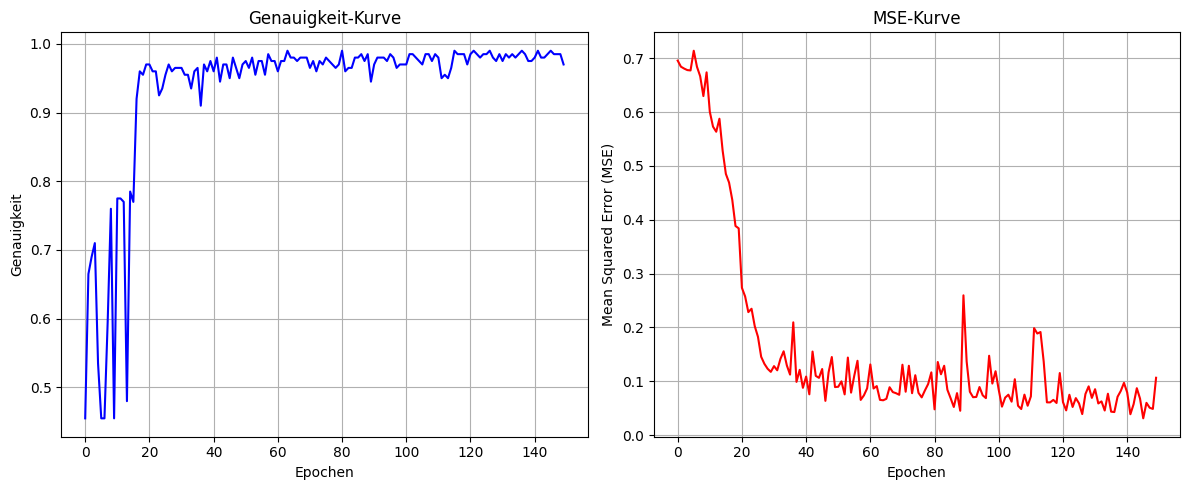

In [290]:
from matplotlib import pyplot as plt

### Darstellen der Lernkurven
# Genauigkeit-Kurve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), precision, label='Genauigkeit', color='blue')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.title('Genauigkeit-Kurve')
plt.grid()
# MSE-Kurve
plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='MSE', color='red')
plt.xlabel('Epochen')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE-Kurve')
plt.grid()
plt.tight_layout()
plt.show()

### Entscheidungsgrenzen visualisieren

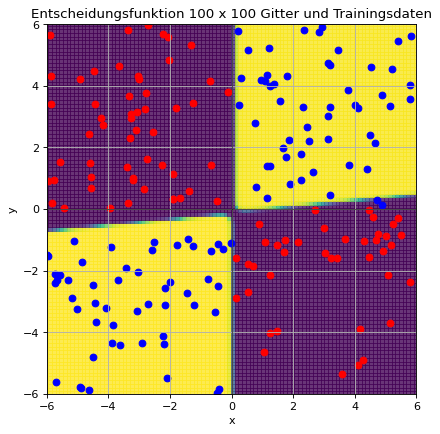

In [291]:
mlp_design_decision = feedforward(design.T)

figure, axis = plt.subplots(1, 1, figsize=(6, 6), dpi=80)
axis_limits = [-6, 6]

# Plot der Entscheidungsfunktion
axis.pcolor(X, Y, mlp_design_decision.reshape(100,100), alpha=.8)
axis.grid(True)
axis.set_title("Entscheidungsfunktion 100 x 100 Gitter und Trainingsdaten")
axis.set_xlabel("x")
axis.set_ylabel("y")
axis.axhline(0, color='black', linewidth=0.5)
axis.axvline(0, color='black', linewidth=0.5)
axis.set_xlim(axis_limits)
axis.set_ylim(axis_limits)
axis.set_aspect('equal')

# Scatter-Plot der Labels
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label='Label 1')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='red', label='Label 0')

plt.show()